<a href="https://colab.research.google.com/github/baofff/U-ViT/blob/main/UViT_ImageNet_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [All are Worth Words: A ViT Backbone for Diffusion Models](https://arxiv.org/abs/2209.12152)

This is a demo for sampling from [U-ViT](https://arxiv.org/abs/2209.12152) on ImageNet. U-ViT is a transformer-based backbone for diffusion models. It treats all inputs as tokens and employs long skip connections.


## Setup the Enviroment

Download repository and install dependence

In [ ]:
!git clone https://github.com/baofff/U-ViT
!pip install timm==0.3.2 einops

Cloning into 'U-ViT'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 71 (delta 37), reused 58 (delta 26), pack-reused 0
Unpacking objects: 100% (71/71), 524.17 KiB | 8.88 MiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 KB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.9 MB/s eta 0:00:00


Fix the bug in [`timm==0.3.2`](https://github.com/rwightman/pytorch-image-models)

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1uDenyYlcB_WayF-aK4dwoWvVfT-IyE_O  # download the debugged helper.py from https://drive.google.com/file/d/1uDenyYlcB_WayF-aK4dwoWvVfT-IyE_O/view
!mv /content/helpers.py /usr/local/lib/python3.8/dist-packages/timm/models/layers/helpers.py  # move the debugged helper.py to timm library

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Downloading...
From: https://drive.google.com/uc?id=1uDenyYlcB_WayF-aK4dwoWvVfT-IyE_O
To: /content/helpers.py
100% 703/703 [00:00<00:00, 1.62MB/s]


Import what we need

In [ ]:
import os
os.chdir('/content/U-ViT')
os.environ['PYTHONPATH'] = '/env/python:/content/U-ViT'

import torch
from dpm_solver_pp import NoiseScheduleVP, DPM_Solver
import libs.autoencoder
from libs.uvit import UViT
import einops
from torchvision.utils import save_image
from PIL import Image

xformers disabled


## Define and Download the U-ViT

In [ ]:
image_size = "256" #@param [256, 512]
image_size = int(image_size)

if image_size == 256:
  !gdown 13StUdrjaaSXjfqqF7M47BzPyhMAArQ4u  # download U-ViT-H/2 on ImageNet 256x256 from https://drive.google.com/file/d/13StUdrjaaSXjfqqF7M47BzPyhMAArQ4u/view?usp=share_link
else:
  !gdown 1uegr2o7cuKXtf2akWGAN2Vnlrtw5YKQq  # download U-ViT-H/4 on ImageNet 512x512 from https://drive.google.com/file/d/1uegr2o7cuKXtf2akWGAN2Vnlrtw5YKQq/view?usp=share_link

z_size = image_size // 8
patch_size = 2 if image_size == 256 else 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

nnet = UViT(img_size=z_size,
       patch_size=patch_size,
       in_chans=4,
       embed_dim=1152,
       depth=28,
       num_heads=16,
       num_classes=1001,
       conv=False)

nnet.to(device)
nnet.load_state_dict(torch.load(f'imagenet{image_size}_uvit_huge.pth', map_location='cpu'))
nnet.eval()

Downloading...
From: https://drive.google.com/uc?id=13StUdrjaaSXjfqqF7M47BzPyhMAArQ4u
To: /content/U-ViT/imagenet256_uvit_huge.pth
100% 2.00G/2.00G [00:28<00:00, 70.2MB/s]


UViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(4, 1152, kernel_size=(2, 2), stride=(2, 2))
  )
  (time_embed): Identity()
  (label_emb): Embedding(1001, 1152)
  (in_blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1152, out_features=3456, bias=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1152, out_features=1152, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1152, out_features=4608, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4608, out_features=1152, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
     

## Define and Download the Autoencoder

In [ ]:
!gdown 10nbEiFd4YCHlzfTkJjZf45YcSMCN34m6  # download the autoencoder from https://drive.google.com/file/d/10nbEiFd4YCHlzfTkJjZf45YcSMCN34m6/view?usp=share_link
autoencoder = libs.autoencoder.get_model('autoencoder_kl_ema.pth')
autoencoder.to(device)

Downloading...
From: https://drive.google.com/uc?id=10nbEiFd4YCHlzfTkJjZf45YcSMCN34m6
To: /content/U-ViT/autoencoder_kl_ema.pth
100% 335M/335M [00:05<00:00, 63.0MB/s]
Create autoencoder with scale_factor=0.18215
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


FrozenAutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
      

## Sample from U-ViT

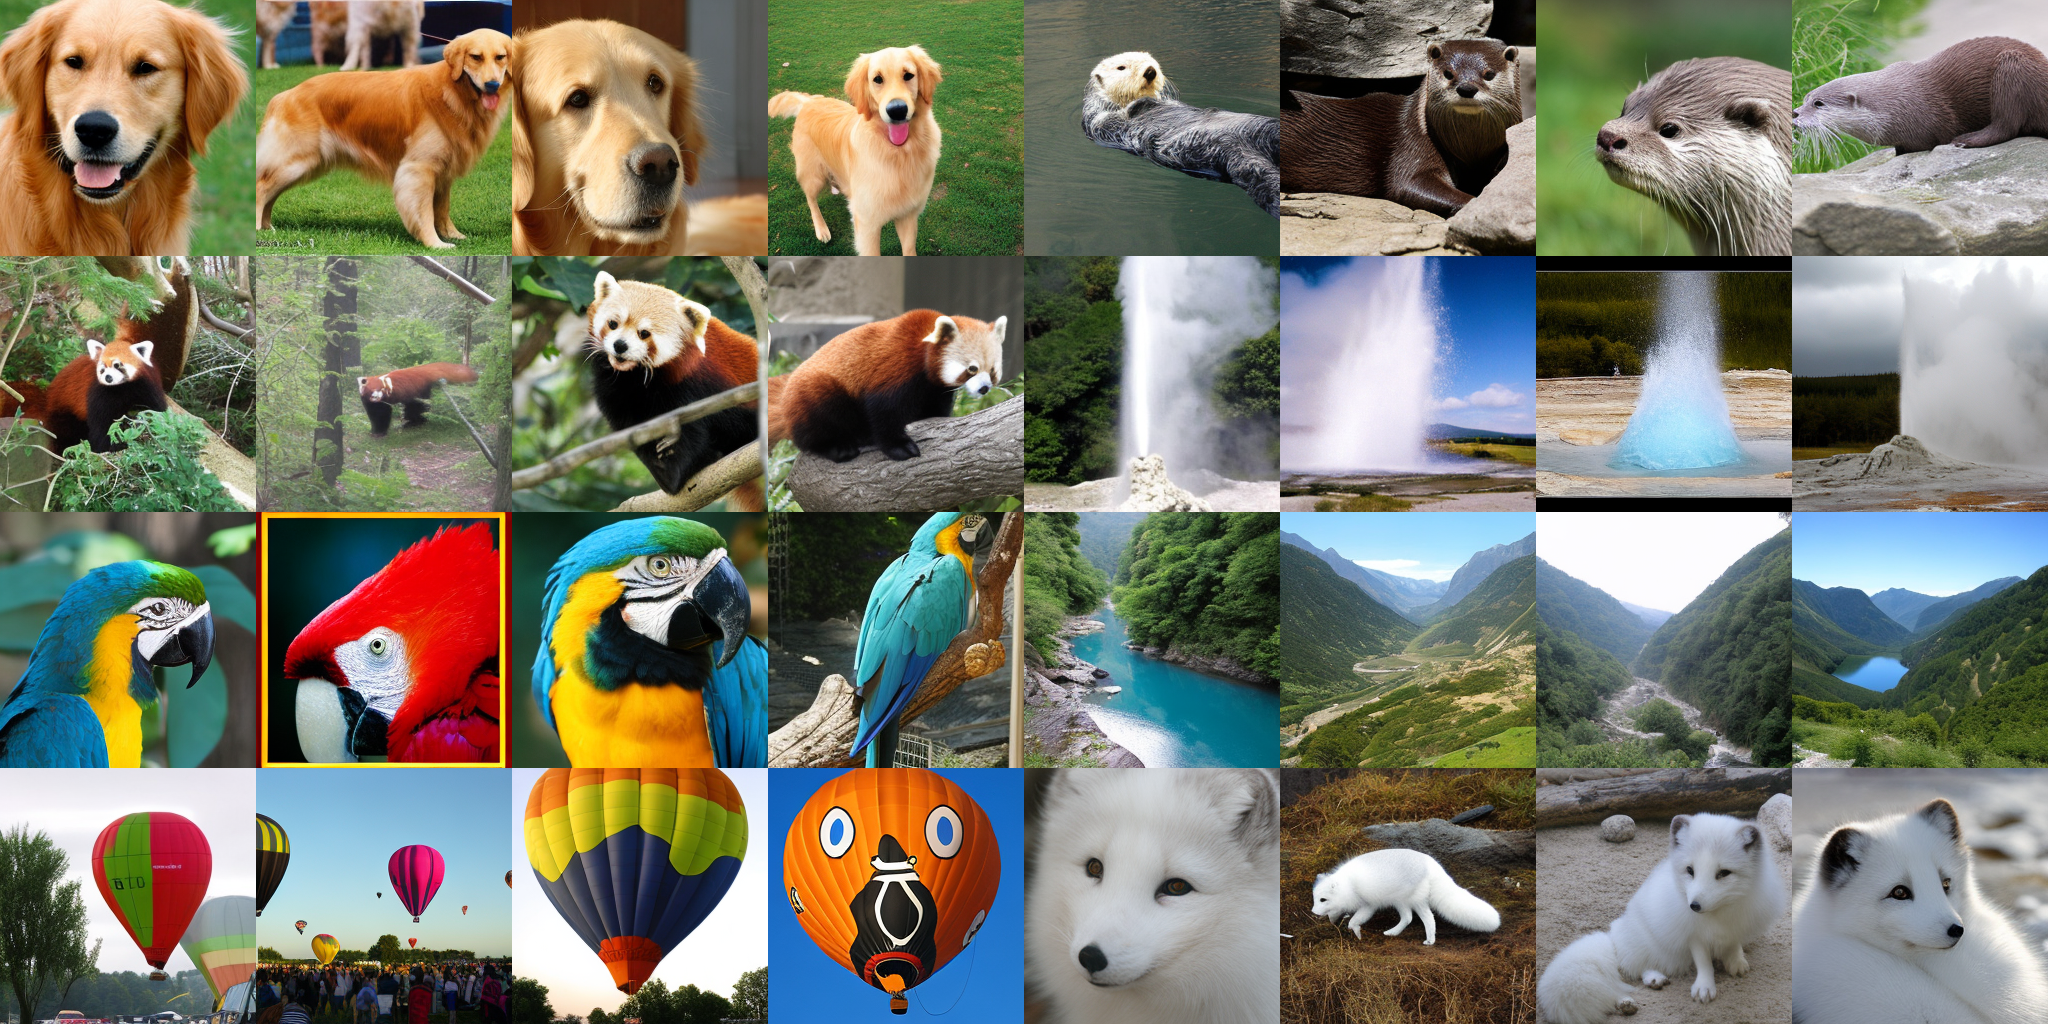

In [ ]:
seed = 1234 #@param {type:"number"}
steps = 25 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 3 #@param {type:"slider", min:0, max:10, step:0.1}
class_labels = 207, 360, 387, 974, 88, 979, 417, 279 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}
torch.manual_seed(seed)

def stable_diffusion_beta_schedule(linear_start=0.00085, linear_end=0.0120, n_timestep=1000):
    _betas = (
        torch.linspace(linear_start ** 0.5, linear_end ** 0.5, n_timestep, dtype=torch.float64) ** 2
    )
    return _betas.numpy()


_betas = stable_diffusion_beta_schedule()  # set the noise schedule
noise_schedule = NoiseScheduleVP(schedule='discrete', betas=torch.tensor(_betas, device=device).float())


y = torch.tensor(class_labels, device=device)
y = einops.repeat(y, 'B -> (B N)', N=samples_per_row)

def model_fn(x, t_continuous):
    t = t_continuous * len(_betas)
    _cond = nnet(x, t, y=y)
    _uncond = nnet(x, t, y=torch.tensor([1000] * x.size(0), device=device))
    return _cond + cfg_scale * (_cond - _uncond)  # classifier free guidance


z_init = torch.randn(len(y), 4, z_size, z_size, device=device)
dpm_solver = DPM_Solver(model_fn, noise_schedule, predict_x0=True, thresholding=False)

with torch.no_grad():
  with torch.cuda.amp.autocast():  # inference with mixed precision
    z = dpm_solver.sample(z_init, steps=steps, eps=1. / len(_betas), T=1.)
    samples = autoencoder.decode(z)
samples = 0.5 * (samples + 1.)
samples.clamp_(0., 1.)
save_image(samples, "sample.png", nrow=samples_per_row * 2, padding=0)
samples = Image.open("sample.png")
display(samples)